In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
import csv
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier
%matplotlib inline

In [14]:
group_data = pd.read_csv('../output/result.csv')
specific_data = pd.read_csv('../output/final_data.csv')

In [15]:
# Merge two datasets into one by key 'Topic_Year'
final_data = group_data.merge(specific_data, how='right', on='Topic_Year')

In [16]:
del group_data
del specific_data

In [17]:
# Filter data after year 2000
final_data = final_data[(final_data.PY >= 2004) & (final_data.PY < 2019)]
final_data.drop(columns=['PY','Cluster_Topic'], inplace=True)

In [18]:
# Missing data imputation by replacing median values
missing_cols = []
for col in final_data.columns:
    if final_data[col].isnull().sum() != 0:
        missing_cols.append(col)
for missing_col in missing_cols:
    final_data[missing_col].fillna(np.nanmedian(final_data[missing_col]), inplace=True)
    
final_data.drop(columns=['Year','Topic','Topic_Year','Growth_Rate','Year_Growth_Rate'], inplace=True)

In [19]:
le = preprocessing.LabelEncoder()
final_data['Squeezed_Publisher'] = le.fit_transform(final_data['Squeezed_Publisher'])

In [20]:
final_data['PT'] = le.fit_transform(final_data['PT'])

In [21]:
def get_acu_with_prob(df):
    y = df['Target'].values
    df = df.drop(['Target'],axis=1)
    X = df.values
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.10, random_state=2)
    #####
    radm = RandomForestClassifier(n_estimators=1000,
                                  max_depth=None,
                                  min_samples_split=10,
                                  class_weight="balanced",
                                  random_state=2).fit(Xtrain, ytrain)
    y_val_1 = radm.predict_proba(Xtest)
    fpr_1, tpr_1, thresholds_1 = metrics.roc_curve(ytest, pd.DataFrame(y_val_1)[1].values, pos_label=1)
    radm_roc_auc = roc_auc_score(ytest, radm.predict(Xtest))
    print("Random Forest Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                       == ytest)/len(ytest))
    print ('auc:', metrics.auc(fpr_1, tpr_1))
    #####

    log_reg = LogisticRegression().fit(Xtrain, ytrain)
    y_val_2 = log_reg.predict_proba(Xtest)
    fpr_2, tpr_2, thresholds_2 = metrics.roc_curve(ytest, pd.DataFrame(y_val_2)[1].values, pos_label=1)
    log_roc_auc = roc_auc_score(ytest, log_reg.predict(Xtest))
    print("Logistic Regression Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values
                                       == ytest)/len(ytest))
    print ('auc:', metrics.auc(fpr_2, tpr_2))
    #####
    gnb = GaussianNB().fit(Xtrain,ytrain)
    y_val_3 = gnb.predict(Xtest)
    fpr_3, tpr_3, thresholds_3 = metrics.roc_curve(ytest, y_val_3, pos_label=1)
    gnb_roc_auc = roc_auc_score(ytest, gnb.predict(Xtest))
    print("Naive Bayes Validation accuracy: ", sum(y_val_3==ytest)/len(ytest))
    print ('auc:', metrics.auc(fpr_3, tpr_3))
    #####
    kNN = KNeighborsClassifier(n_neighbors=25).fit(Xtrain, ytrain)
    y_val_4 = kNN.predict(Xtest)
    y_prob_4 = kNN.predict_proba(Xtest)
    fpr_4, tpr_4, thresholds_4 = metrics.roc_curve(ytest, pd.DataFrame(y_prob_4)[1].values, pos_label=1)
    acu =  sum(y_val_4==ytest)/len(ytest)
    kNN_roc_auc = roc_auc_score(ytest, kNN.predict(Xtest))
    print("kNN Validation accuracy: ",acu)
    print ('auc:', metrics.auc(fpr_4, tpr_4))
    ####
#     svm = SVC(C=249,kernel='rbf',probability = True).fit(Xtrain,ytrain)
#     val_5 = svm.predict(Xtest)
#     val_prob_5 = svm.predict_proba(Xtest)
#     fpr_5, tpr_5, thresholds_5 = metrics.roc_curve(ytest, pd.DataFrame(val_prob_5)[1].values, pos_label=1)
#     svm_roc_auc = roc_auc_score(ytest, svm.predict(Xtest))
#     print("SVM Validation accuracy: ", sum(val_5==ytest)/len(ytest))
#     print ('auc:', metrics.auc(fpr_5, tpr_5))
    ####
    ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.1).fit(Xtrain,ytrain)
    ada_roc_auc = roc_auc_score(ytest, ada.predict(Xtest))
    val_6 = ada.predict(Xtest)
    val_prob_6 = ada.predict_proba(Xtest)
    fpr_6, tpr_6, thresholds_6 = metrics.roc_curve(ytest, pd.DataFrame(val_prob_6)[1], pos_label=1)
    ada_roc_auc = roc_auc_score(ytest, ada.predict(Xtest))
    print("ADA Validation accuracy: ", sum(val_6==ytest)/len(ytest))
    print("AdaBoost AUC = %2.2f" % ada_roc_auc)
    
    
    

    plt.figure()

    # Plot Random Forest ROC
    plt.plot(fpr_1, tpr_1, label='Random Forest (area = %0.2f)' % metrics.auc(fpr_1, tpr_1))

    # Plot Logistic Regression ROC
    plt.plot(fpr_2, tpr_2, label=' (Logistic Regression area = %0.2f)' % metrics.auc(fpr_2, tpr_2))

    
    # Plot kNN ROC
    plt.plot(fpr_4, tpr_4, label='KNN (area = %0.2f)' % metrics.auc(fpr_4, tpr_4))
    
#     # Plot SVM ROC
#     plt.plot(fpr_5, tpr_5, label='SVM (area = %0.2f)' % metrics.auc(fpr_5, tpr_5))
    
    # Plot ADA ROC
    plt.plot(fpr_6, tpr_6, label='ada (area = %0.2f)' % metrics.auc(fpr_6, tpr_6))

    # Plot Base Rate ROC
    plt.plot([0,1], [0,1],label='Base Rate' 'k--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Graph')
    plt.legend(loc="lower right")
    plt.show()

Random Forest Validation accuracy:  1.0
auc: 1.0
Logistic Regression Validation accuracy:  0.8421318514776459
auc: 0.9118652504537345
Naive Bayes Validation accuracy:  0.6342510735034099
auc: 0.6349038542536164
kNN Validation accuracy:  1.0
auc: 1.0
ADA Validation accuracy:  0.9161404395049255
AdaBoost AUC = 0.92


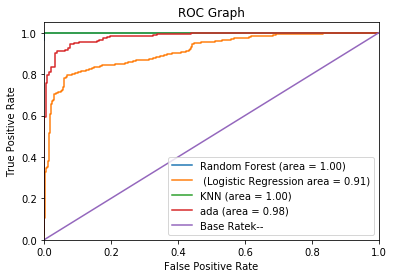

In [22]:
get_acu_with_prob(final_data)